In [9]:
rewards = []

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np

# Создание нейронной сети для оценки Q-значений
class DQNNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Agent:
    def __init__(self, input_size, output_size, alpha=0.45, epsilon=1.0, gamma=0.9, batch_size=64):
        self.alpha = alpha  # коэффициент обучения
        self.epsilon = epsilon  # коэффициент исследования
        self.gamma = gamma  # коэффициент дисконтирования
        self.batch_size = batch_size
        self.output_size = output_size

        # Создание нейронной сети для оценки Q-значений
        self.q_network = DQNNetwork(input_size, output_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)
        self.criterion = nn.MSELoss()
        
    def get_possible_actions(self, state):
        return [i for i, value in enumerate(state) if value == 0]

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            possible_actions = self.get_possible_actions(state)
            return random.choice(possible_actions)  # случайное действие среди доступных
        else:
            q_values = self.q_network(torch.tensor(state).float())
            possible_actions = self.get_possible_actions(state)
            masked_q_values = q_values.clone()
            for i in range(self.output_size):
                if i not in possible_actions:
                    masked_q_values[i] = float('-inf')  # Присваиваем -inf для недоступных действий
            return torch.argmax(masked_q_values).item()  # выбираем наилучшее из доступных действий

    def learn(self, state, action, reward, next_state, done):
        q_values = self.q_network(torch.tensor(state).float())
        next_q_values = self.q_network(torch.tensor(next_state).float())

        q_update = reward
        if not done:
            q_update = reward + self.gamma * torch.max(next_q_values).item()

        q_values[action] = q_update
        target_q_values = self.q_network(torch.tensor(state).float())
        loss = self.criterion(target_q_values, q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > 0.01:
            self.epsilon *= 0.995  # Exponential decay of epsilon

In [3]:
def check(state, symbol, possible_actions):
        winning_combinations = [[0, 1, 2], [1, 2, 0], [3, 4, 5], [4, 5, 3], [6, 7, 8], [7, 8, 6], [0, 2, 1], [3, 5, 4], [6, 8, 7], # горизонтальные
                            [0, 3, 6], [3, 6, 0], [2, 5, 8], [5, 8, 2], [1, 4, 7], [4, 7, 1], [0, 6, 3], [1, 7, 4], [2, 8, 5],  # вертикальные
                            [0, 8, 4], [0, 4, 8], [4,8, 0], [2, 4, 6], [4, 6, 2], [2, 6, 4]]  # диагональные
    
        for combination in winning_combinations:
            if state[combination[0]] == state[combination[1]] == symbol:
                if combination[2] in possible_actions:
                    return { True: combination[2] }
        return { False: combination[0] }

In [4]:
class DefaultAgent:
    
    def get_possible_actions(self, state):
        return [i for i, value in enumerate(state) if value == 0]
    
    def choose_action(self, state, possible_actions):
        result_check = check(state, -1, possible_actions)
        for key in result_check:
            if key:
                action = result_check[key]
            else:
                action = random.choice(possible_actions)
        return action

In [5]:
def play_game(agent1, agent2):
    state = [0, 0, 0, 0, 0, 0, 0, 0, 0]  # начальное состояние доски
    game_over = False
    
    while not game_over:
        # Ход первого агента
        action1 = agent1.choose_action(tuple(state))
        state[action1] = 1

        # Проверка на победу/ничью
        if check_winner(state, 1):
            rewards.append(1)
            agent1.learn(tuple(state), action1, 1, tuple(state), True)
            game_over = True
            break

        if not 0 in state:  # ничья
            rewards.append(0)
            agent1.learn(tuple(state), action1, 0, tuple(state), True)
            game_over = True
            break

        # Ход второго агента
        action2 = agent2.choose_action(tuple(state), agent2.get_possible_actions(state))
        state[action2] = -1

        # Проверка на победу/ничью
        if check_winner(state, -1):
            rewards.append(-1)
            agent1.learn(tuple(state), action1, -1, tuple(state), True)
            game_over = True
            break

    return game_over

def check_winner(state, symbol):
    winning_combinations = [[0, 1, 2], [3, 4, 5], [6, 7, 8],  # горизонтальные
                            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # вертикальные
                            [0, 4, 8], [2, 4, 6]]  # диагональные
    
    for combination in winning_combinations:
        if state[combination[0]] == state[combination[1]] == state[combination[2]] == symbol:
            return True
    return False

In [10]:
training_volume = 5000

In [11]:
agent1 = Agent(9, 9)
agent2 = DefaultAgent()

total_games = 1000 * training_volume

for i in range(total_games):
    play_game(agent1, agent2)

print("Studying complete!")

analysis_rewards = []

counter = 0
for index, data in enumerate(rewards):
    if data == 1:
        counter = counter + 1
    if index % training_volume == 0:
        analysis_rewards.append(counter)
        counter = 0

Studying complete!


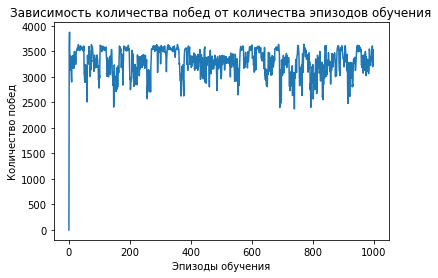

In [12]:
import matplotlib.pyplot as plt
result = total_games/training_volume
plt.plot(range(int(result)), analysis_rewards)
plt.xlabel('Эпизоды обучения')
plt.ylabel('Количество побед')
plt.title('Зависимость количества побед от количества эпизодов обучения')
plt.show()